In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Multiply, Add, Softmax, Layer, Dropout, Flatten, Reshape, TimeDistributed, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras

from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from IPython.display import display           

In [2]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
print("Number of classes:", n_classes)

Number of classes: 8


In [3]:
final_data = np.load("..\\full_and_half_Final_data.npy")
final_data.shape

(11674, 200, 6)

In [4]:
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [5]:
label = np.load("..\\full_and_half_label.npy")
label.shape

(11674,)

In [6]:
label

array([0, 0, 0, ..., 5, 6, 7], dtype=int64)

In [7]:
frequency = np.bincount(label)
frequency

array([1520, 1480, 1540,  279,  279, 3288, 1644, 1644], dtype=int64)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'walking_stairs_updown'),
  Text(3, 0, 'stumble_while_walking'),
  Text(4, 0, 'Fall_Recovery'),
  Text(5, 0, 'Fall_Initiation'),
  Text(6, 0, 'Impact'),
  Text(7, 0, 'Aftermath')])

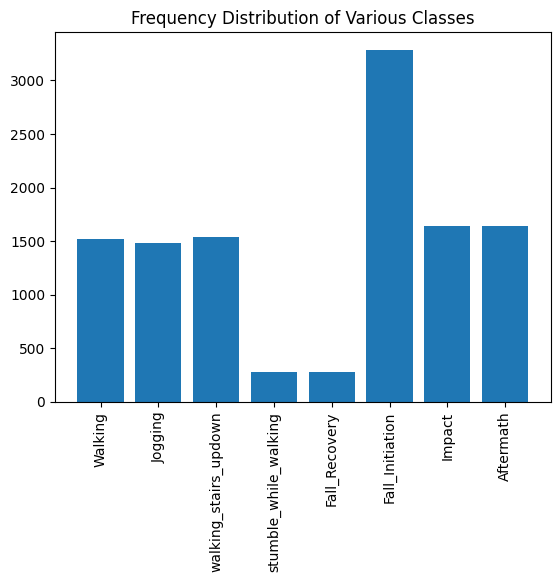

In [8]:
# plt.figure(dpi=300)
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Various Classes")
plt.xticks(rotation=90)

In [9]:
label = to_categorical(label, n_classes)
label.shape

(11674, 8)

In [10]:
label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
final_data = zscore(final_data, axis=1)
final_data.shape

(11674, 200, 6)

In [12]:
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [13]:
I_Shape = final_data.shape[1:]
print(I_Shape)

(200, 6)


In [14]:
# Set input shape and number of classes
input_shape = I_Shape
num_classes = n_classes

In [15]:
def selective_kernel_conv(inputs, kernel_sizes, filters, use_bn=True, dropout_rate=0.3):
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
        if use_bn:
            conv_output = BatchNormalization()(conv_output)
        conv_outputs.append(conv_output)

    if len(conv_outputs) > 1:
        combined_output = Add()(conv_outputs)
    else:
        combined_output = conv_outputs[0]

    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)

    weighted_output = Multiply()([combined_output, excitation])
    
    if dropout_rate:
        weighted_output = Dropout(dropout_rate)(weighted_output)
    
    return weighted_output

# Define attention mechanism
def attention_block(inputs):
    # Compute attention scores
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Apply attention scores to the inputs
    attention_output = Multiply()([inputs, attention_scores])
    
    return attention_output

def ENSEMBLE(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # x = selective_kernel_conv(inputs, kernel_sizes=[3, 5, 7], filters=64, dropout_rate=0.3)
    x = selective_kernel_conv(inputs, kernel_sizes=[3, 5, 7], filters=64)
    x = attention_block(x)
    
    # x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7], filters=128, dropout_rate=0.3)
    x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7], filters=128)
    x = attention_block(x)

    x = GlobalAveragePooling1D()(x)
    # x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Build and compile the updated model
# model = build_amsknet(input_shape, num_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Initialize variables
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
sk_ensemble_scores = []

# Set up KFold cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# i = 0

# # Perform 5-fold cross-validation
# for train_index, test_index in folds.split(final_data):
#     i += 1
#     print("Fold", i)

#     # Split data for the current fold
#     X_train, X_test = final_data[train_index], final_data[test_index]
#     y_train, y_test = label[train_index], label[test_index]

#     # Build and compile the model
#     ensemble = ENSEMBLE(I_Shape, n_classes)
#     ensemble.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     sk_history_ensemble = ensemble.fit(
#         X_train,
#         y_train,
#         batch_size=batch_size,
#         epochs=50,
#         shuffle=True,
#         validation_split=0.1,
#         verbose=1,
#         callbacks=[early_stopping]
#     )

#     # Evaluate the model
#     sk_results_ensemble = ensemble.evaluate(X_test, y_test, batch_size=batch_size)
#     sk_ensemble_scores.append(sk_results_ensemble)

#     # Make predictions
#     sk_predictions_ensemble = ensemble.predict(X_test)

#     # Generate confusion matrix
#     sk_cm_ensemble = tf.math.confusion_matrix(y_test.argmax(axis=1), np.argmax(sk_predictions_ensemble, axis=1))
    
#     # Generate classification report
#     classification_report_df = pd.DataFrame(
#         classification_report(y_test.argmax(axis=1), sk_predictions_ensemble.argmax(axis=1), output_dict=True)
#     ).rename(
#         columns=dict(zip([str(i) for i in range(0, n_classes)], list([class_labels[i] for i in range(0, n_classes)])))
#     ).T
#     print(classification_report_df)

#     # Plot confusion matrix as a heatmap
#     axis_labels = [label for label in class_labels]
#     figure, ax = plt.subplots(figsize=(10, 10), dpi=300)
#     sns.heatmap(sk_cm_ensemble, 
#                 annot=True,
#                 xticklabels=axis_labels, 
#                 yticklabels=axis_labels,
#                 linewidths=0.5,
#                 square=True,
#                 fmt='d',
#                 ax=ax)
#     plt.title(f'Confusion Matrix for Fold {i}')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

Fold 1
Epoch 1/30
263/263 [==============================] - 24s 79ms/step - loss: 1.5344 - accuracy: 0.4255 - val_loss: 1.8094 - val_accuracy: 0.3340
Epoch 2/30
263/263 [==============================] - 20s 78ms/step - loss: 0.9738 - accuracy: 0.6620 - val_loss: 1.1188 - val_accuracy: 0.6263
Epoch 3/30
263/263 [==============================] - 20s 77ms/step - loss: 0.7896 - accuracy: 0.7340 - val_loss: 0.8249 - val_accuracy: 0.7077
Epoch 4/30
263/263 [==============================] - 21s 80ms/step - loss: 0.6894 - accuracy: 0.7716 - val_loss: 0.7597 - val_accuracy: 0.7441
Epoch 5/30
263/263 [==============================] - 21s 81ms/step - loss: 0.6434 - accuracy: 0.7960 - val_loss: 0.6641 - val_accuracy: 0.7752
Epoch 6/30
263/263 [==============================] - 22s 82ms/step - loss: 0.5913 - accuracy: 0.8119 - val_loss: 0.6870 - val_accuracy: 0.7762
Epoch 7/30
263/263 [==============================] - 22s 84ms/step - loss: 0.5579 - accuracy: 0.8268 - val_loss: 0.5812 - val_ac

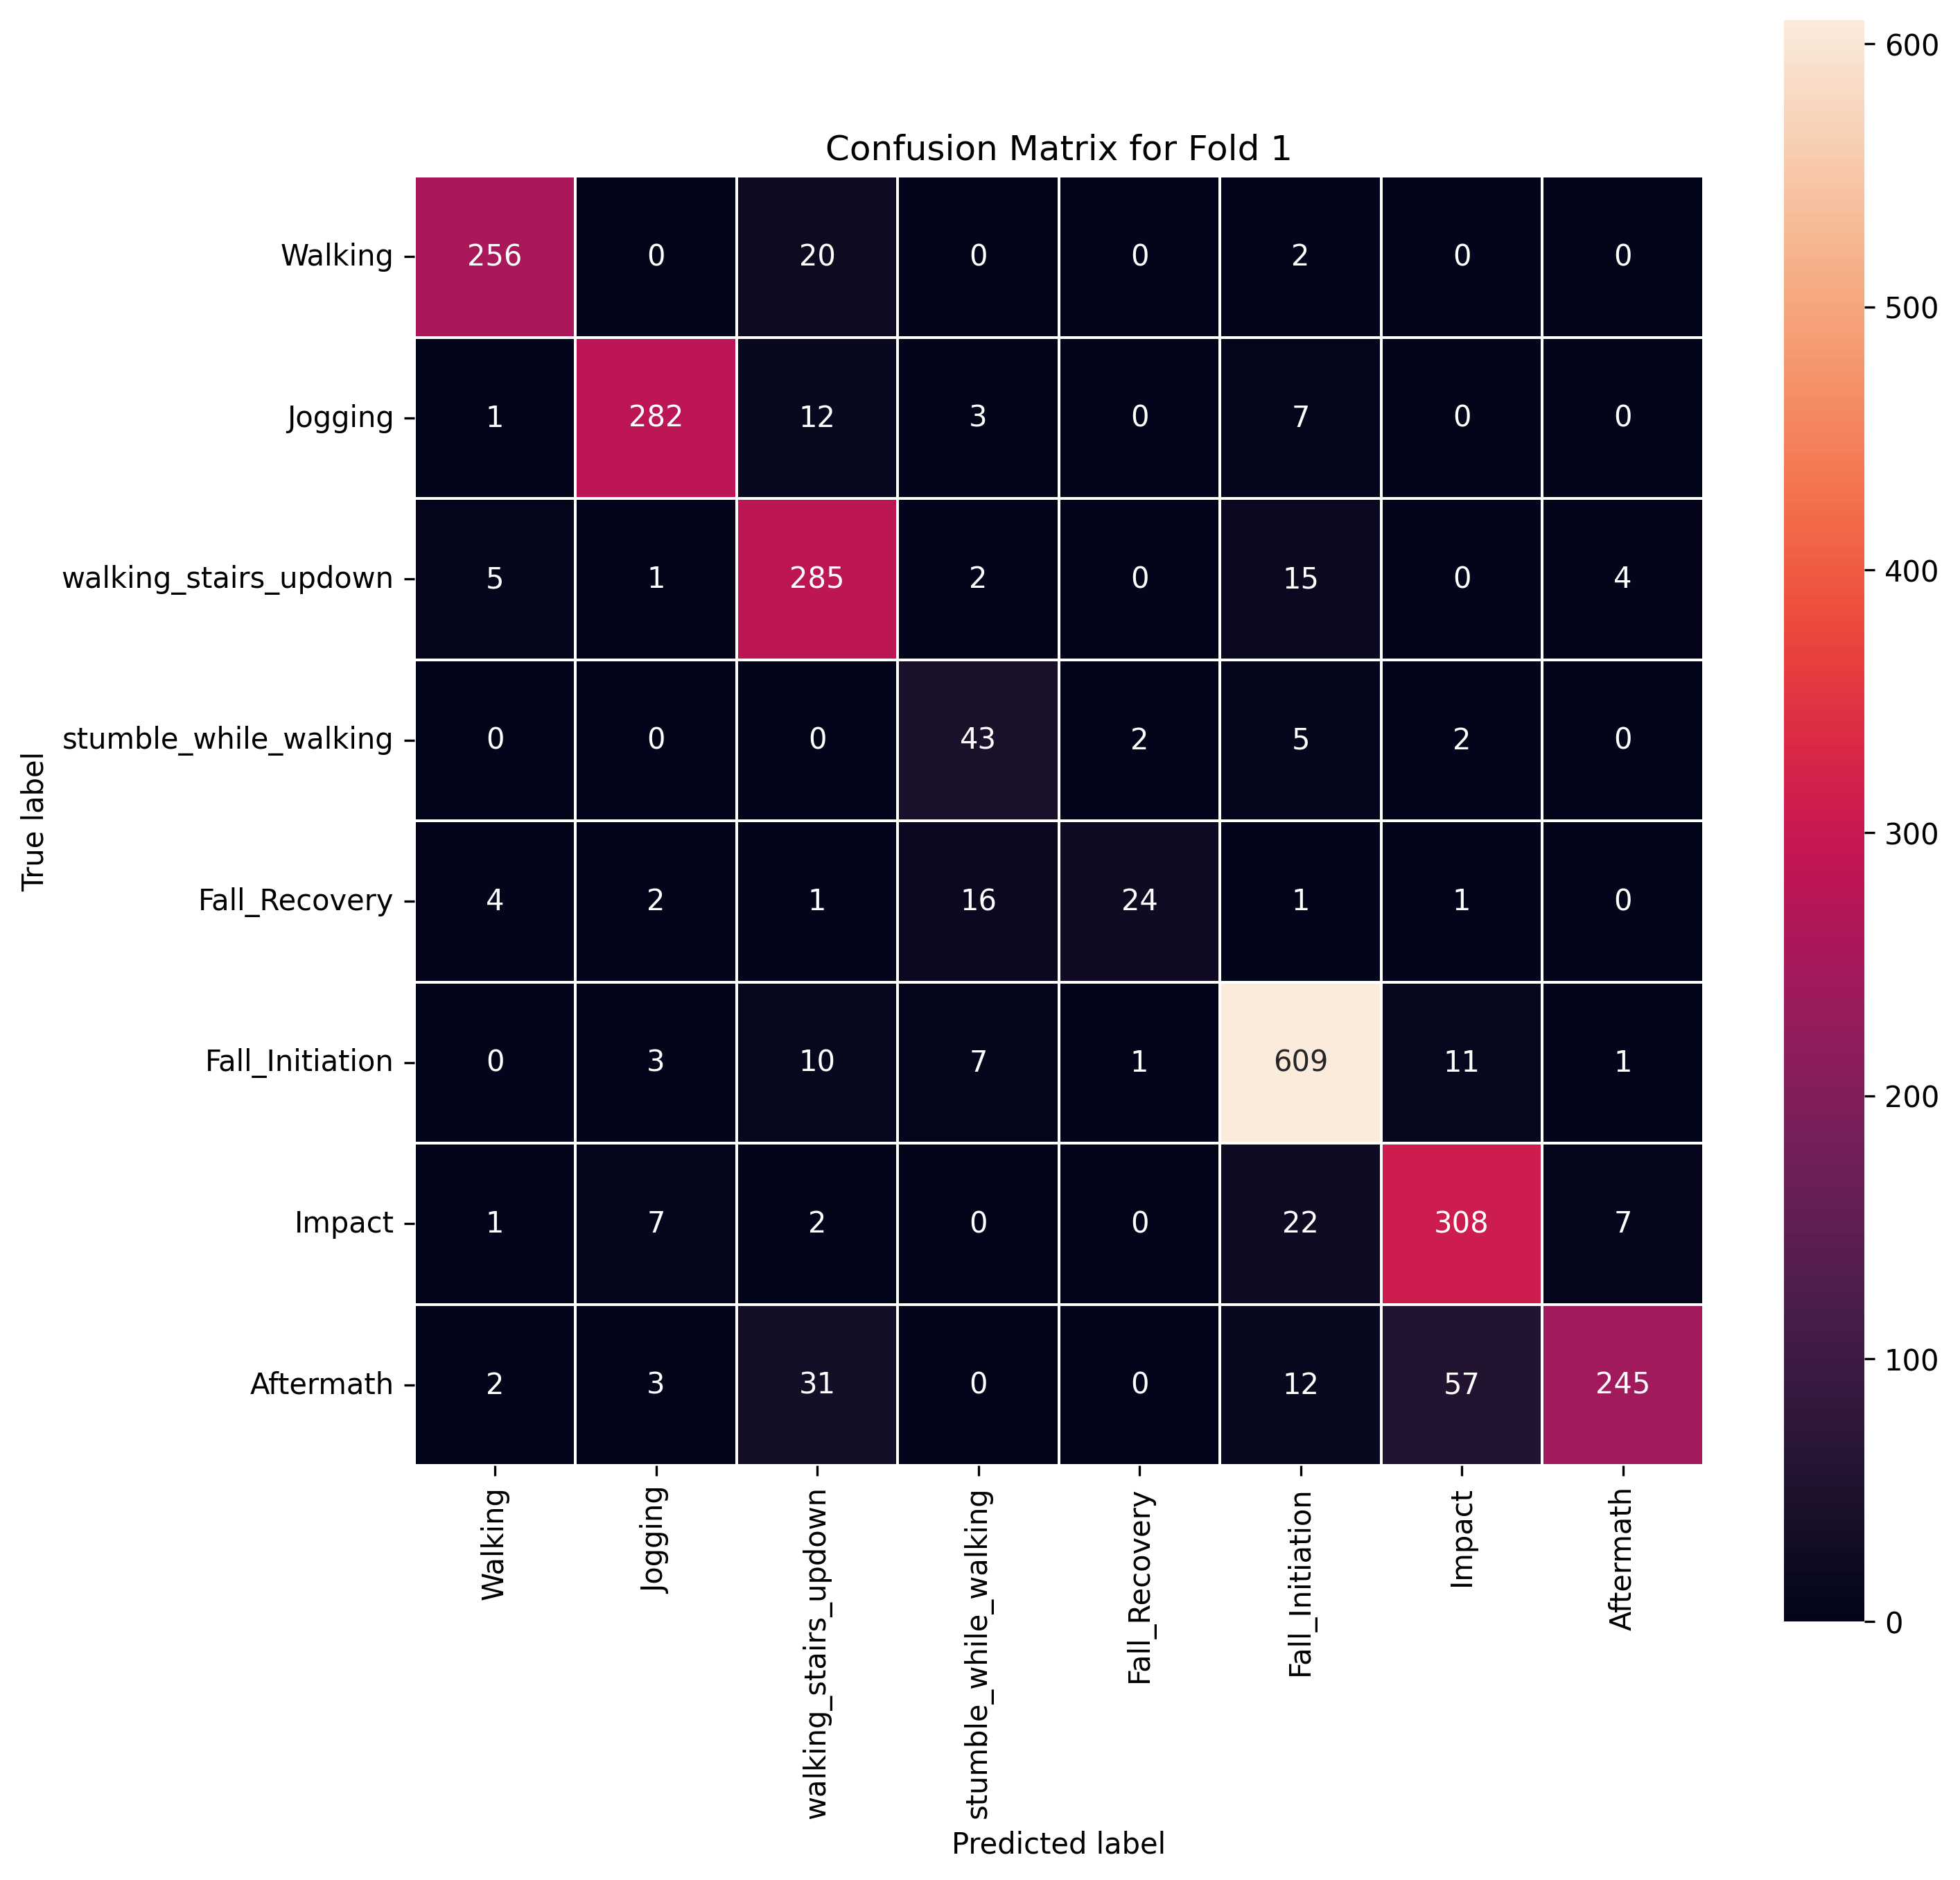

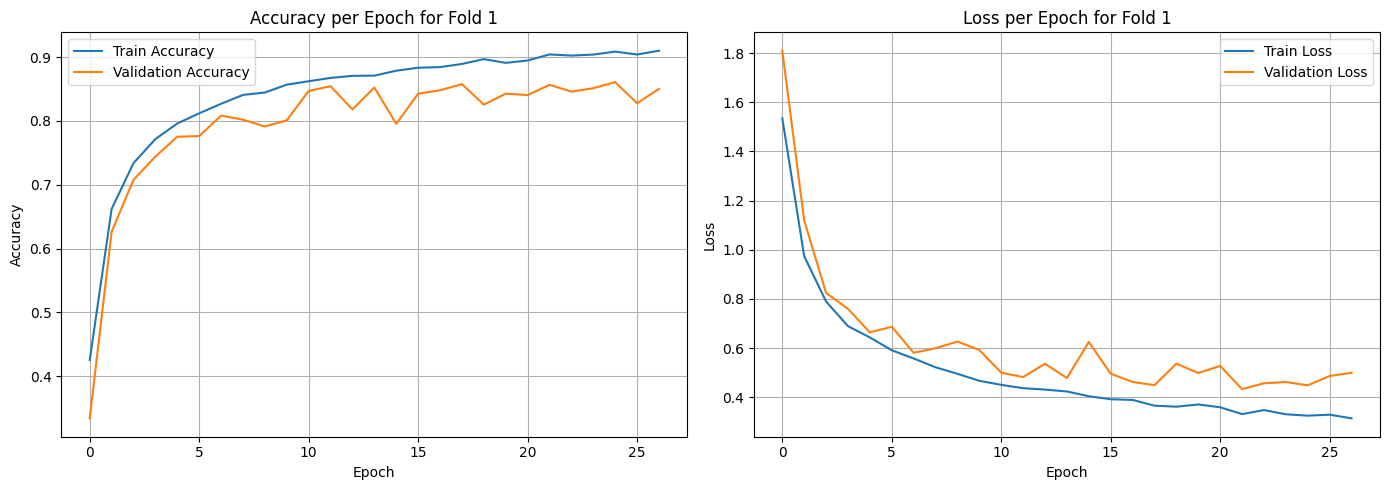

Fold 2
Epoch 1/30
263/263 [==============================] - 24s 81ms/step - loss: 1.5607 - accuracy: 0.4244 - val_loss: 1.7688 - val_accuracy: 0.4636
Epoch 2/30
263/263 [==============================] - 21s 81ms/step - loss: 0.9508 - accuracy: 0.6815 - val_loss: 1.0254 - val_accuracy: 0.6745
Epoch 3/30
263/263 [==============================] - 21s 82ms/step - loss: 0.7786 - accuracy: 0.7437 - val_loss: 0.9641 - val_accuracy: 0.6702
Epoch 4/30
263/263 [==============================] - 21s 81ms/step - loss: 0.7099 - accuracy: 0.7706 - val_loss: 0.7761 - val_accuracy: 0.7334
Epoch 5/30
263/263 [==============================] - 22s 82ms/step - loss: 0.6513 - accuracy: 0.7904 - val_loss: 0.7091 - val_accuracy: 0.7559
Epoch 6/30
263/263 [==============================] - 21s 79ms/step - loss: 0.6072 - accuracy: 0.8071 - val_loss: 0.7096 - val_accuracy: 0.7591
Epoch 7/30
263/263 [==============================] - 22s 82ms/step - loss: 0.5876 - accuracy: 0.8164 - val_loss: 0.6881 - val_ac

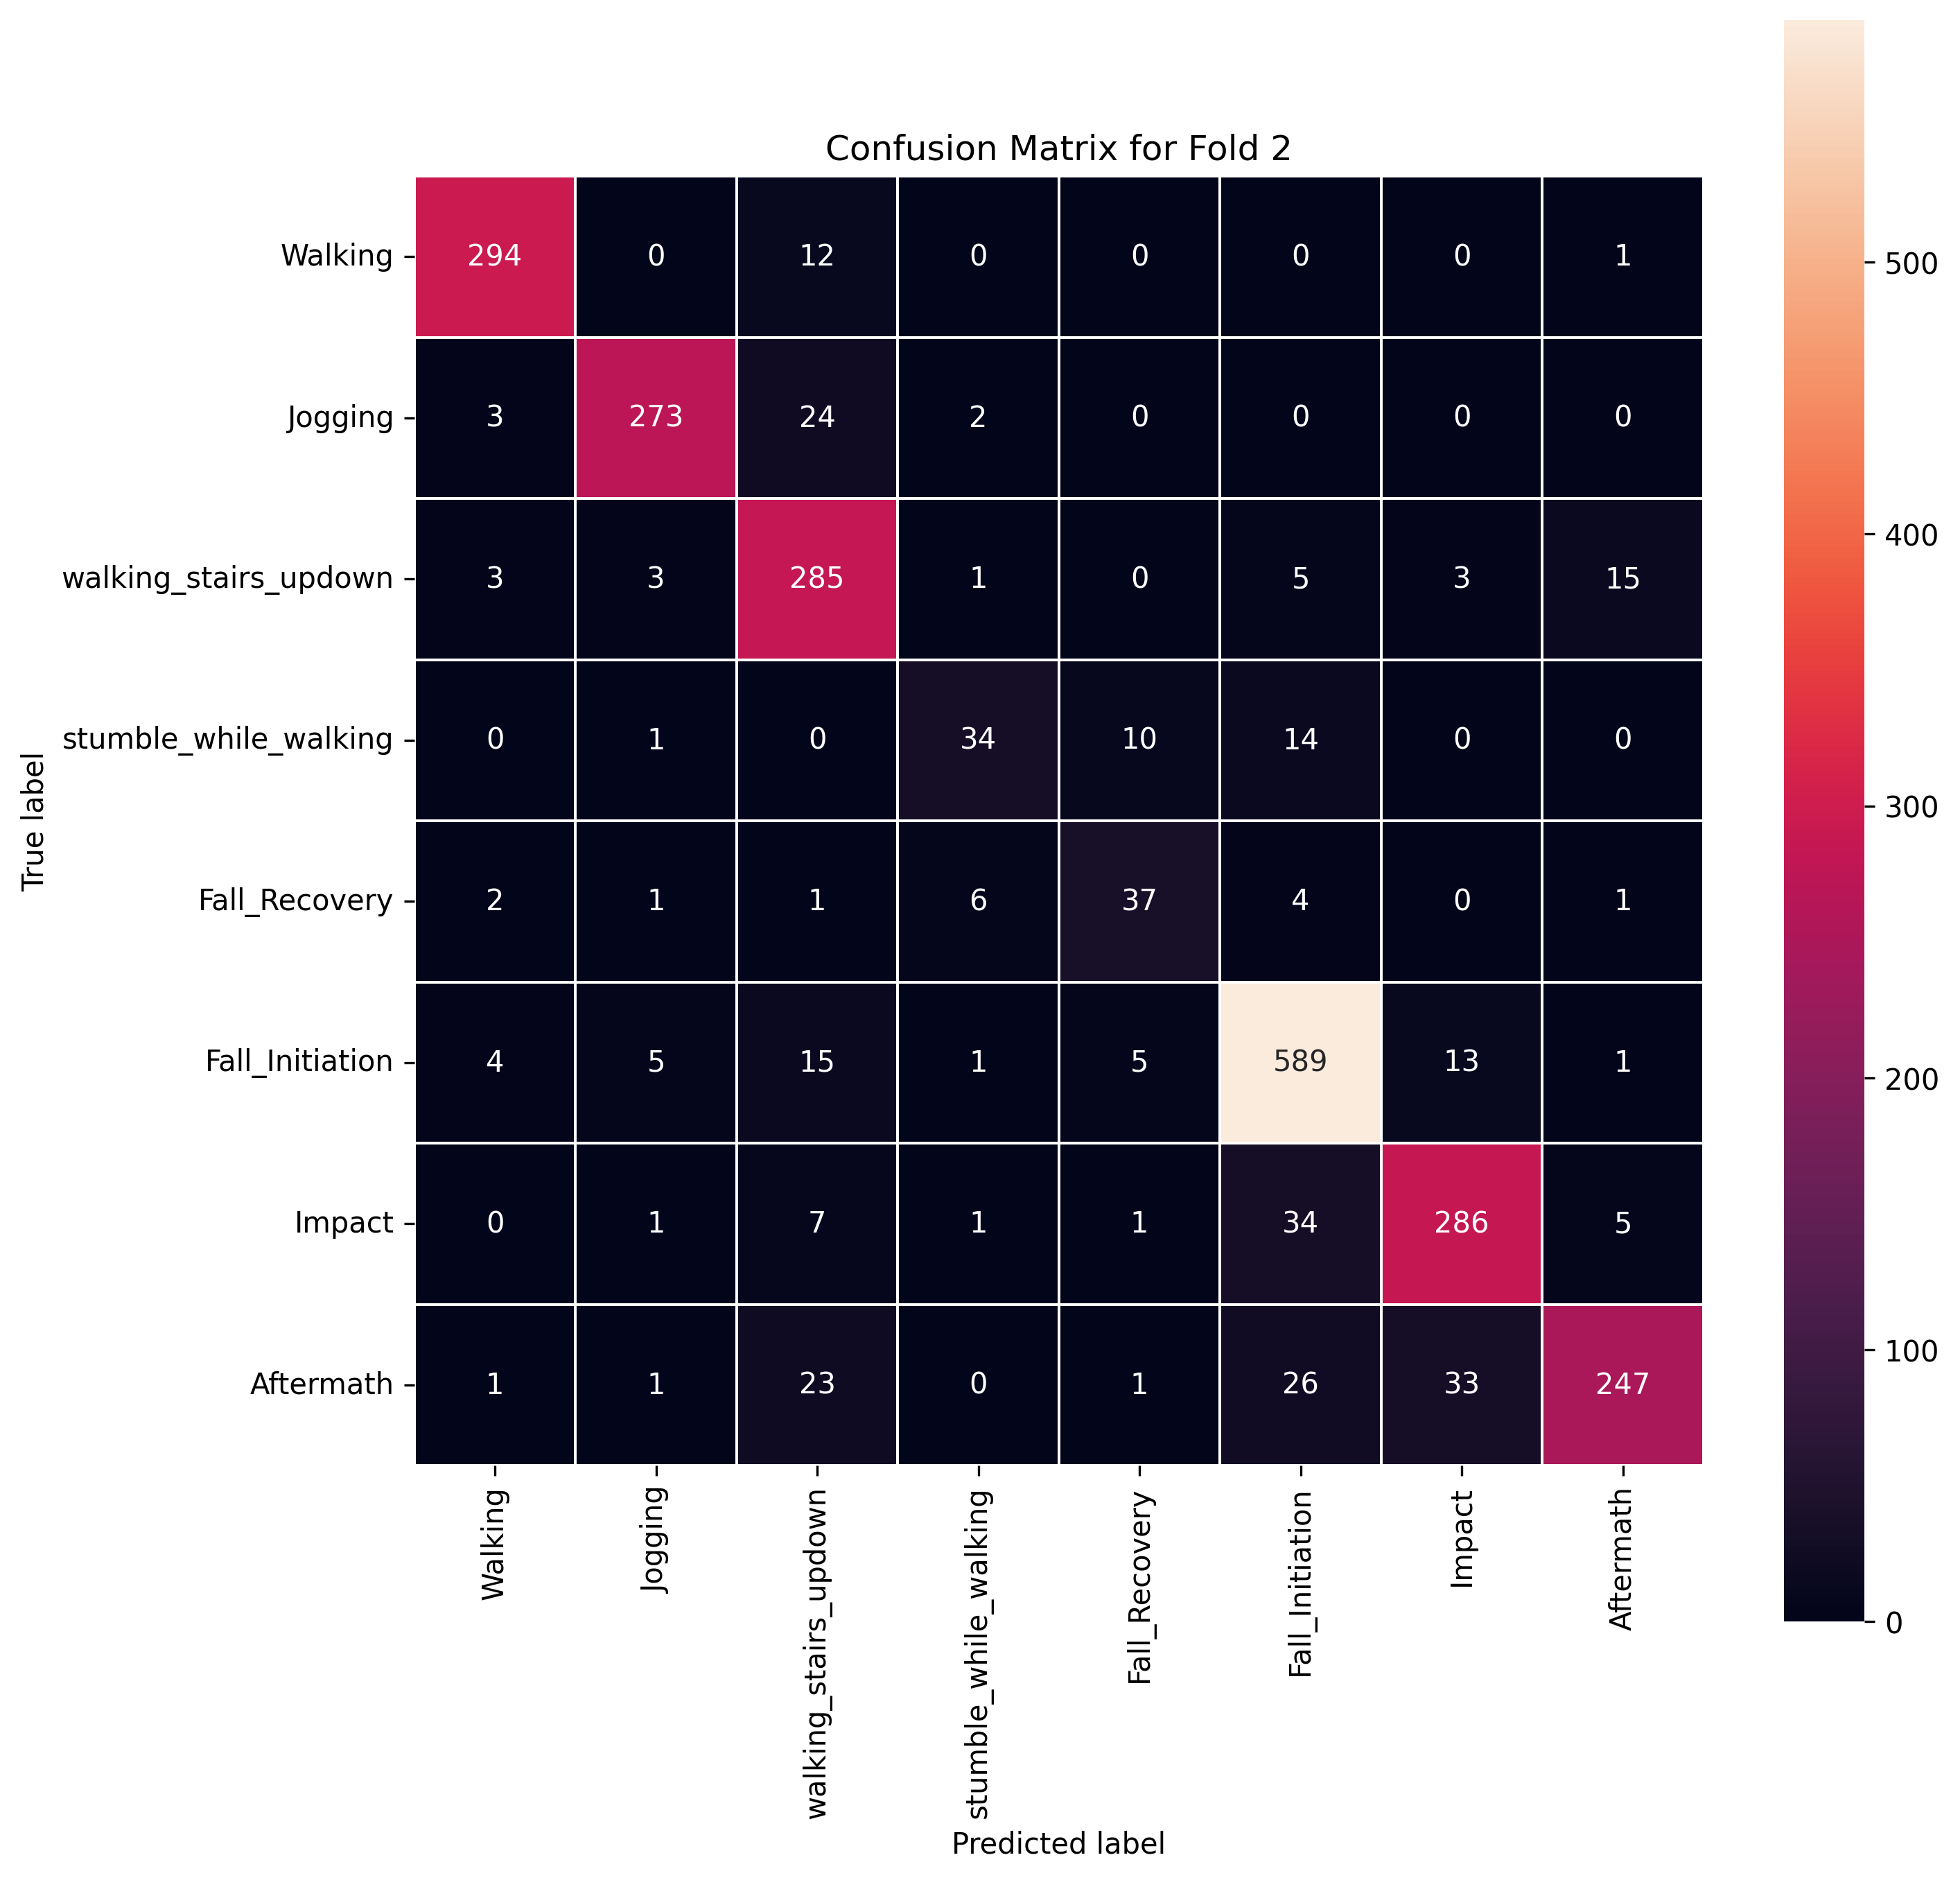

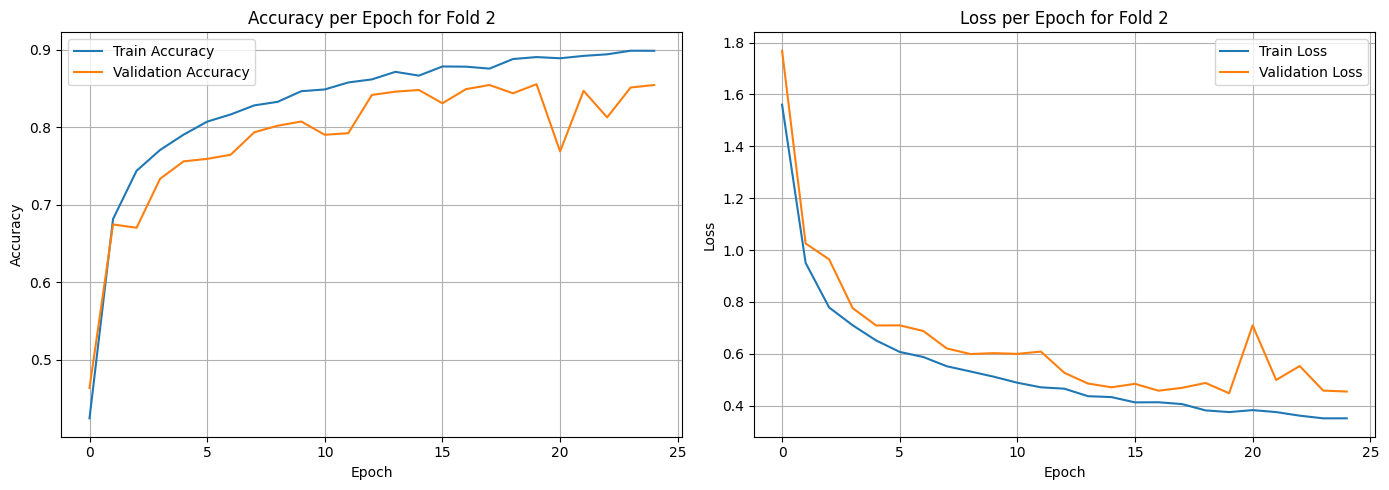

Fold 3
Epoch 1/30
263/263 [==============================] - 26s 85ms/step - loss: 1.5555 - accuracy: 0.4126 - val_loss: 1.7808 - val_accuracy: 0.4047
Epoch 2/30
263/263 [==============================] - 23s 86ms/step - loss: 0.9729 - accuracy: 0.6590 - val_loss: 0.9973 - val_accuracy: 0.6670
Epoch 3/30
263/263 [==============================] - 22s 83ms/step - loss: 0.7622 - accuracy: 0.7472 - val_loss: 0.8387 - val_accuracy: 0.7034
Epoch 4/30
263/263 [==============================] - 22s 86ms/step - loss: 0.6999 - accuracy: 0.7681 - val_loss: 0.8394 - val_accuracy: 0.7109
Epoch 5/30
263/263 [==============================] - 23s 86ms/step - loss: 0.6354 - accuracy: 0.7913 - val_loss: 0.6532 - val_accuracy: 0.7880
Epoch 6/30
263/263 [==============================] - 24s 89ms/step - loss: 0.5872 - accuracy: 0.8128 - val_loss: 0.7597 - val_accuracy: 0.7270
Epoch 7/30
263/263 [==============================] - 23s 86ms/step - loss: 0.5574 - accuracy: 0.8221 - val_loss: 0.6492 - val_ac

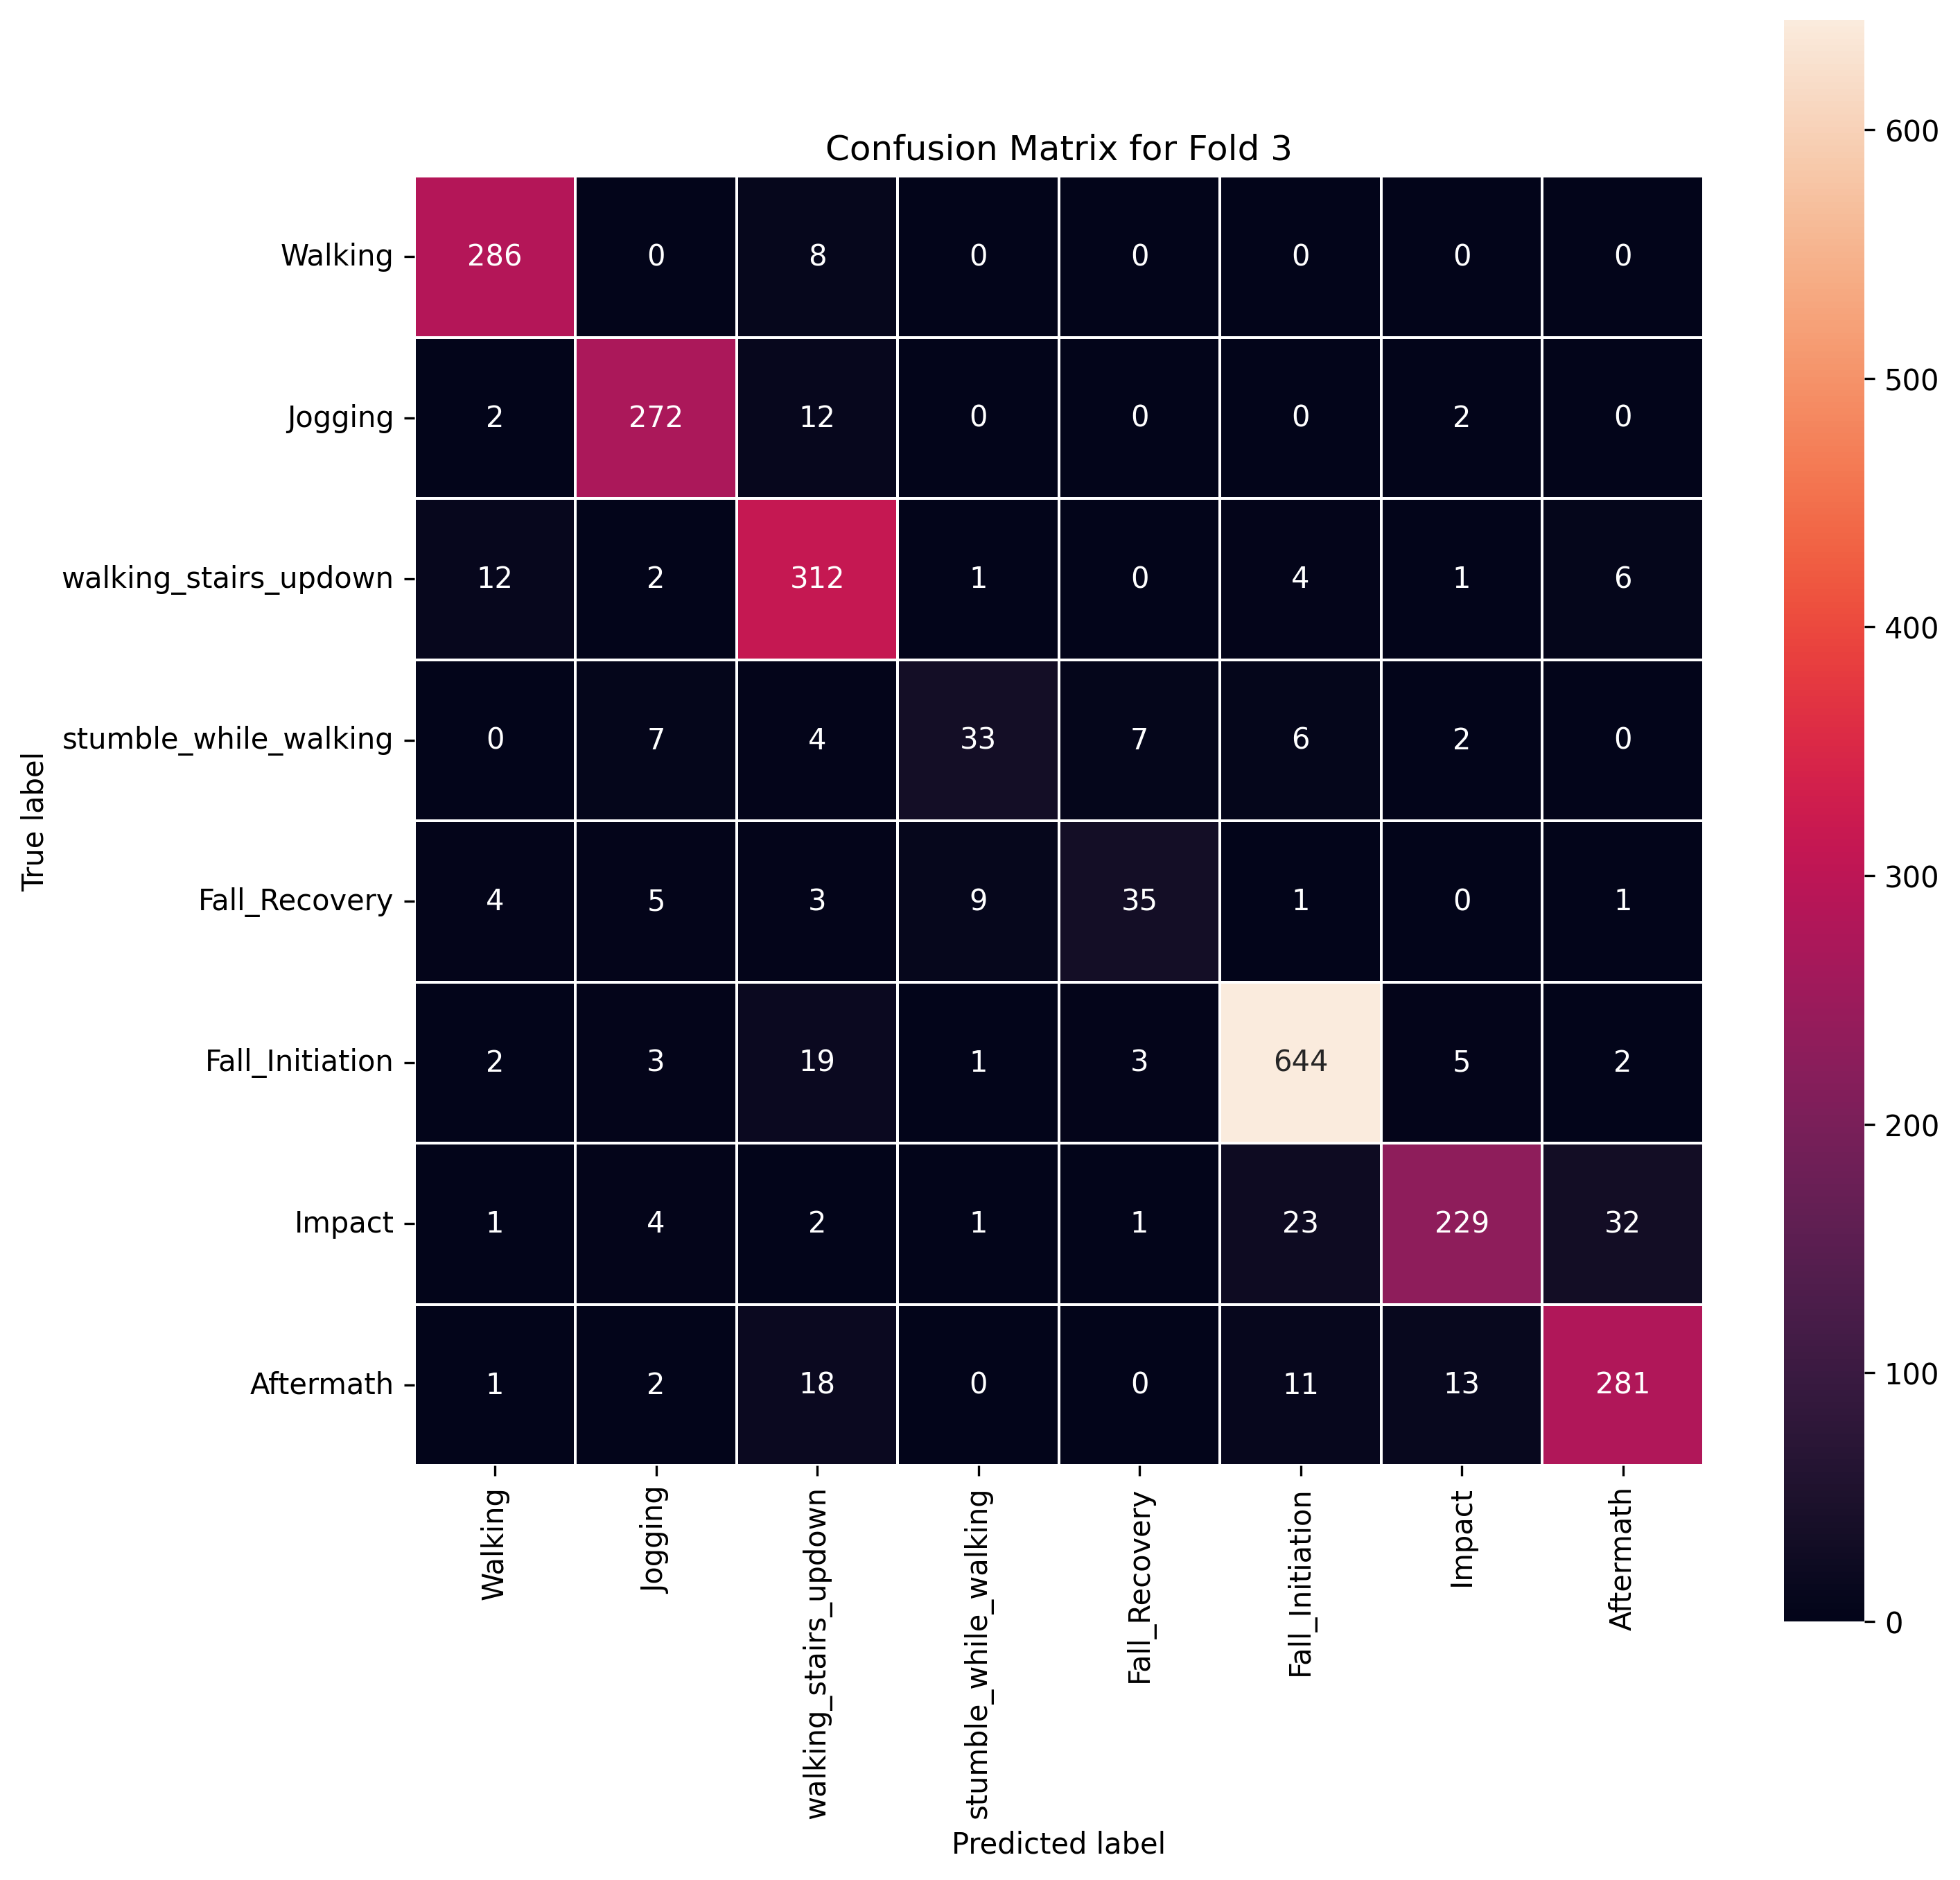

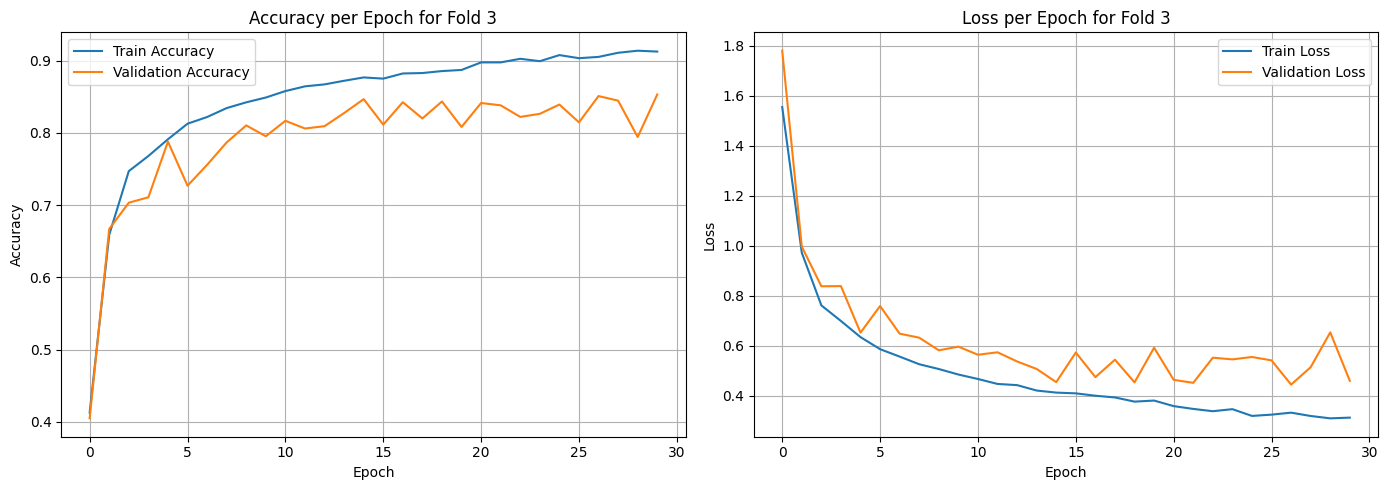

Fold 4
Epoch 1/30
263/263 [==============================] - 28s 85ms/step - loss: 1.5544 - accuracy: 0.4153 - val_loss: 1.7847 - val_accuracy: 0.4700
Epoch 2/30
263/263 [==============================] - 22s 85ms/step - loss: 0.9443 - accuracy: 0.6828 - val_loss: 1.0236 - val_accuracy: 0.6949
Epoch 3/30
263/263 [==============================] - 24s 92ms/step - loss: 0.7450 - accuracy: 0.7604 - val_loss: 0.7864 - val_accuracy: 0.7216
Epoch 4/30
263/263 [==============================] - 24s 90ms/step - loss: 0.6576 - accuracy: 0.7861 - val_loss: 0.6793 - val_accuracy: 0.7666
Epoch 5/30
263/263 [==============================] - 22s 84ms/step - loss: 0.6144 - accuracy: 0.8042 - val_loss: 0.6116 - val_accuracy: 0.7859
Epoch 6/30
263/263 [==============================] - 22s 83ms/step - loss: 0.5740 - accuracy: 0.8237 - val_loss: 0.5859 - val_accuracy: 0.8019
Epoch 7/30
263/263 [==============================] - 22s 85ms/step - loss: 0.5369 - accuracy: 0.8289 - val_loss: 0.6437 - val_ac

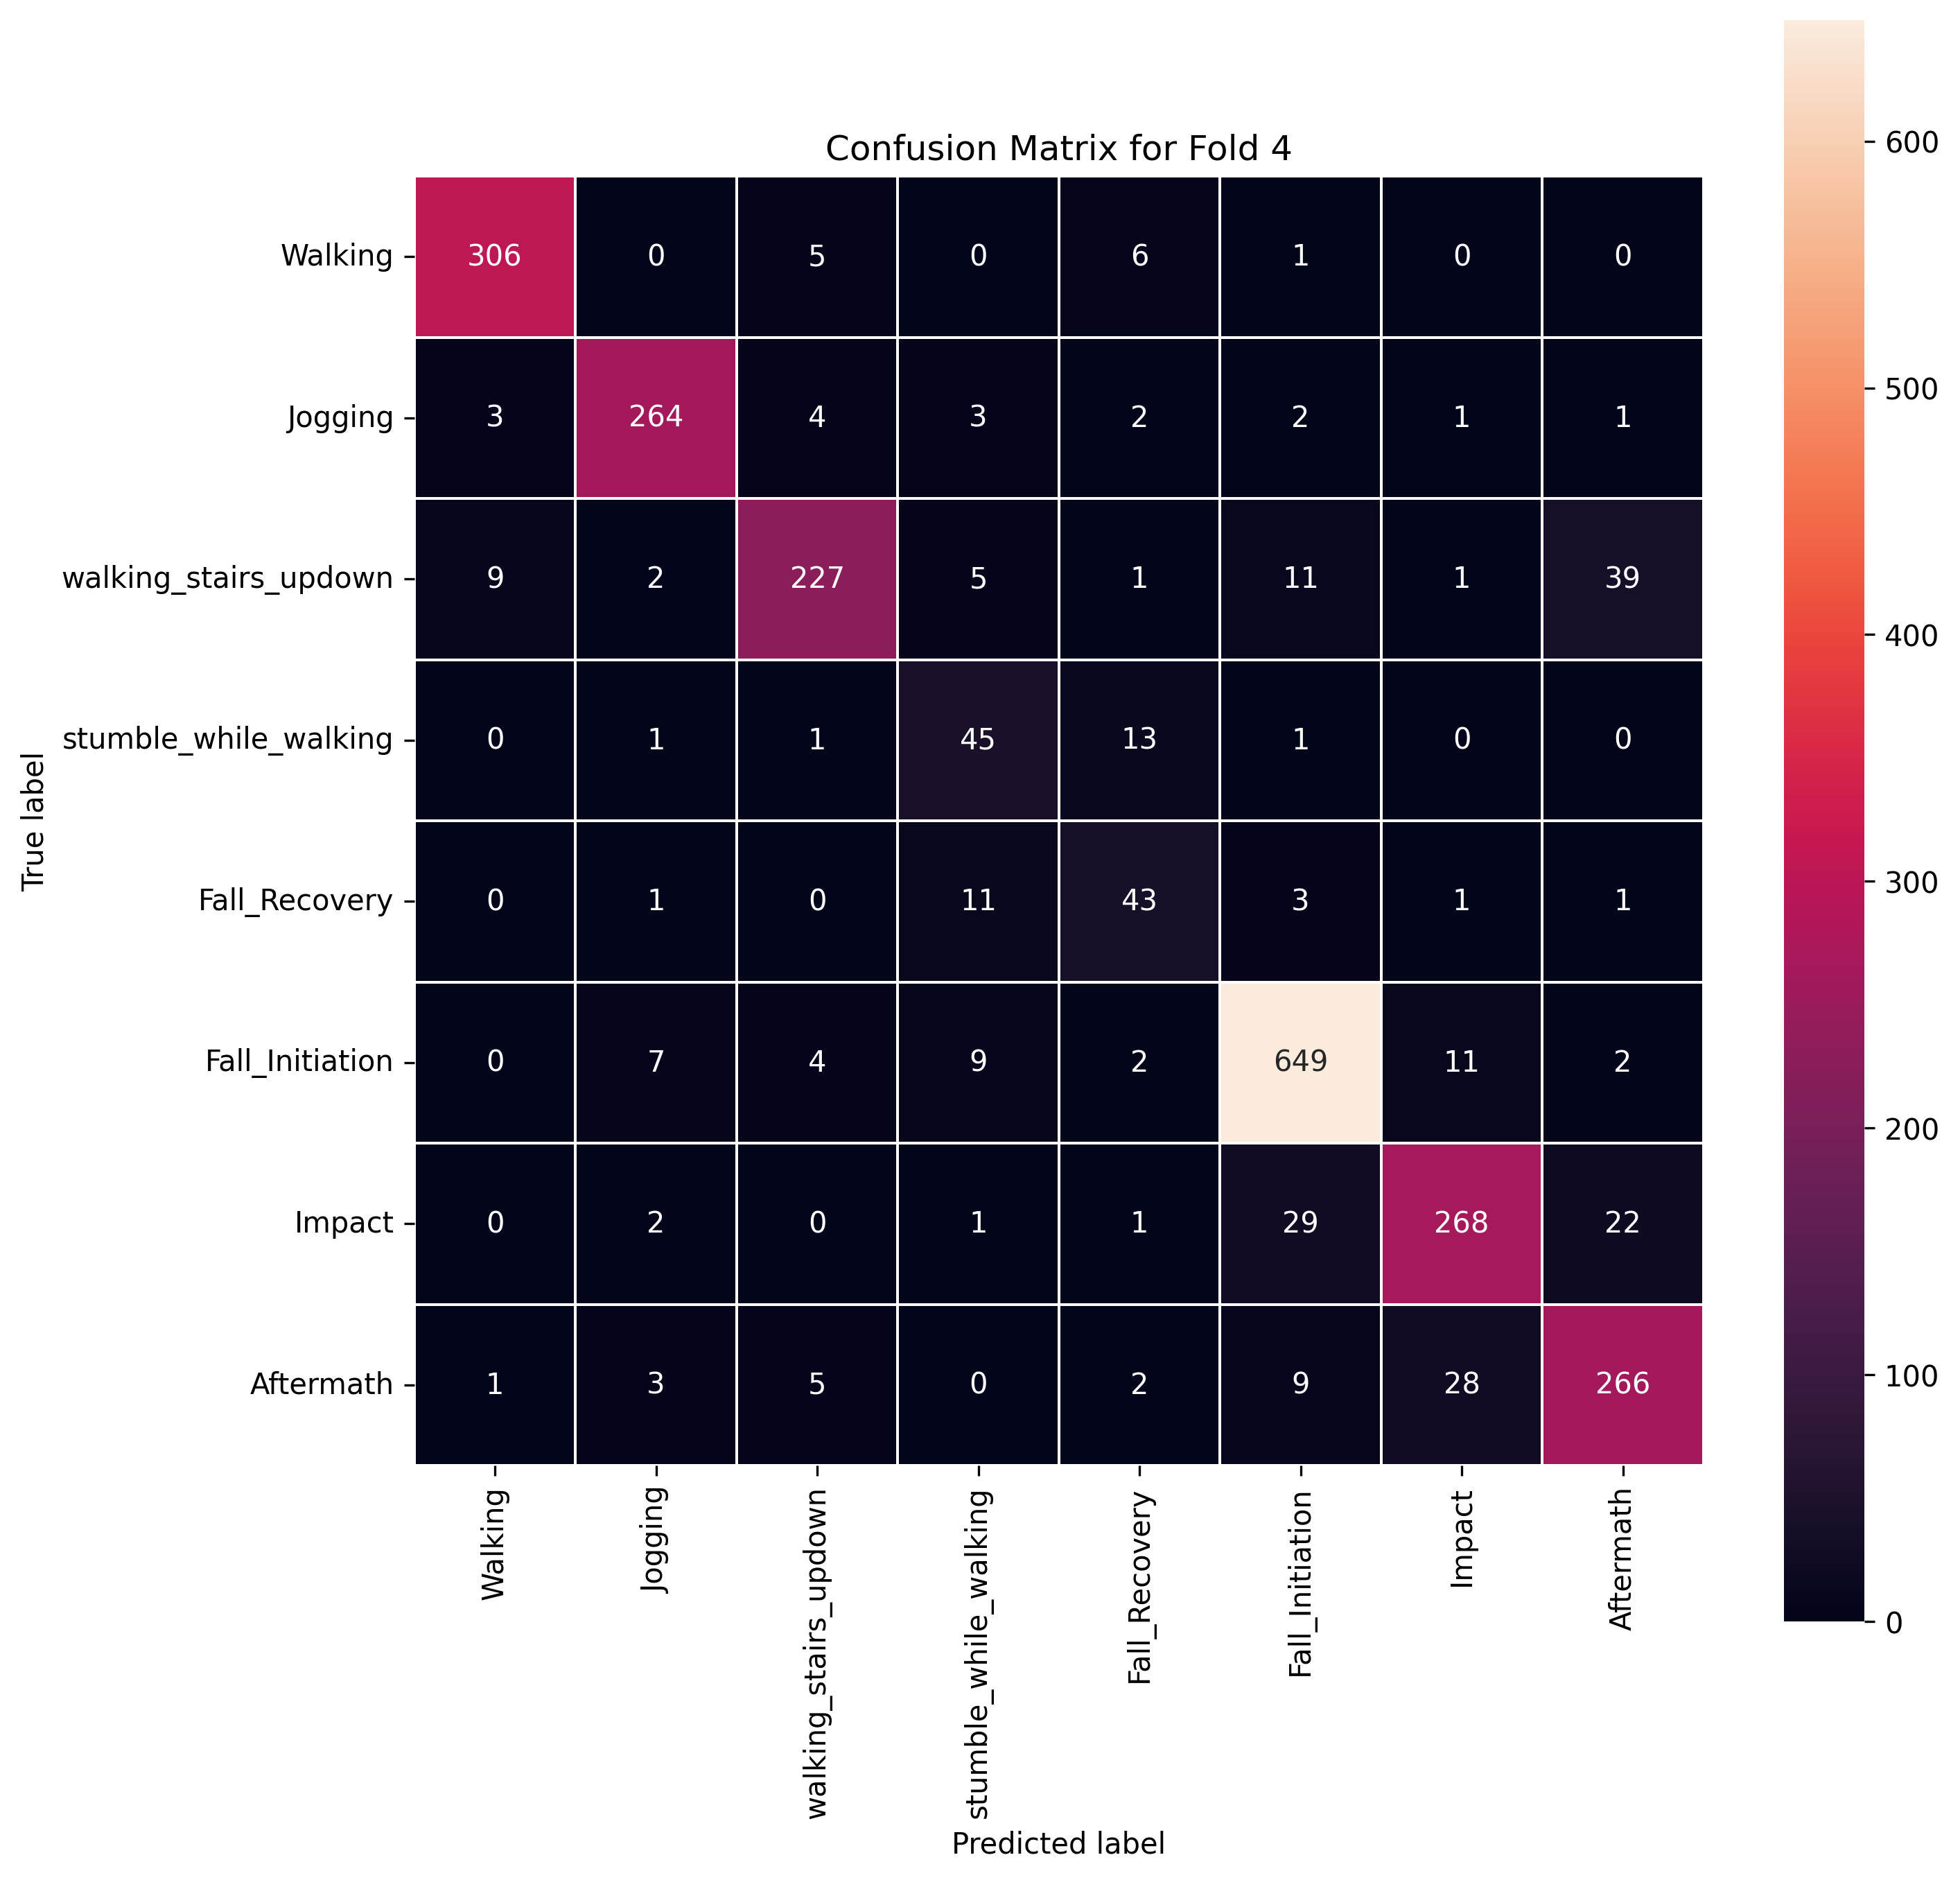

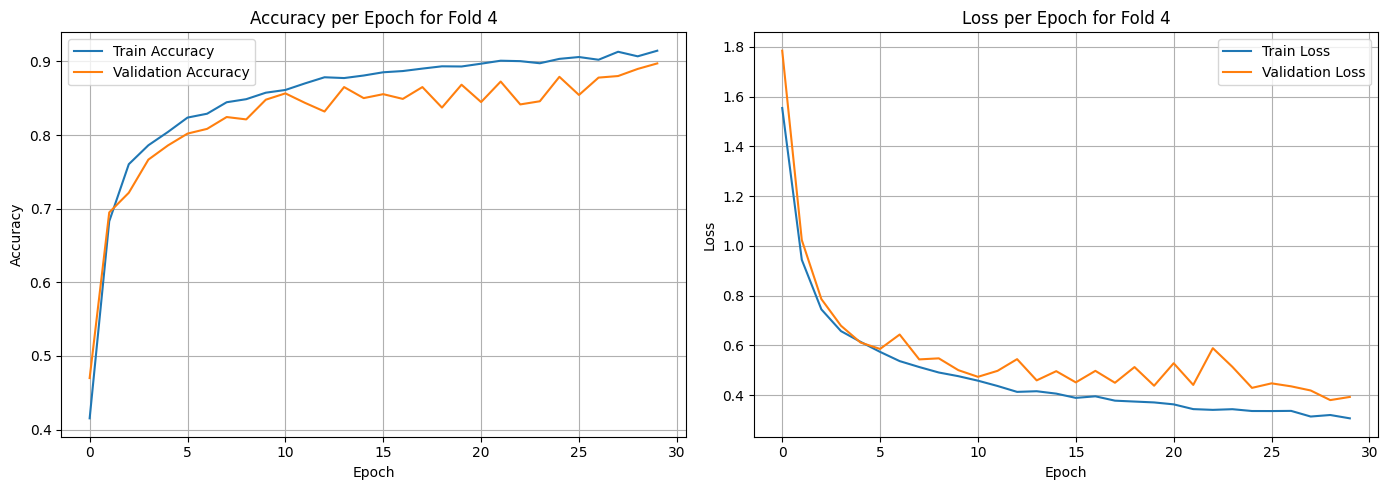

Fold 5
Epoch 1/30
263/263 [==============================] - 26s 86ms/step - loss: 1.5495 - accuracy: 0.4240 - val_loss: 1.8275 - val_accuracy: 0.4133
Epoch 2/30
263/263 [==============================] - 21s 81ms/step - loss: 0.9740 - accuracy: 0.6743 - val_loss: 1.0180 - val_accuracy: 0.6552
Epoch 3/30
263/263 [==============================] - 22s 84ms/step - loss: 0.7816 - accuracy: 0.7422 - val_loss: 0.7985 - val_accuracy: 0.7227
Epoch 4/30
263/263 [==============================] - 21s 81ms/step - loss: 0.6912 - accuracy: 0.7784 - val_loss: 0.8005 - val_accuracy: 0.7141
Epoch 5/30
263/263 [==============================] - 22s 83ms/step - loss: 0.6405 - accuracy: 0.7950 - val_loss: 0.8235 - val_accuracy: 0.7281
Epoch 6/30
263/263 [==============================] - 22s 84ms/step - loss: 0.6002 - accuracy: 0.8122 - val_loss: 0.7201 - val_accuracy: 0.7602
Epoch 7/30
263/263 [==============================] - 22s 83ms/step - loss: 0.5707 - accuracy: 0.8208 - val_loss: 0.6985 - val_ac

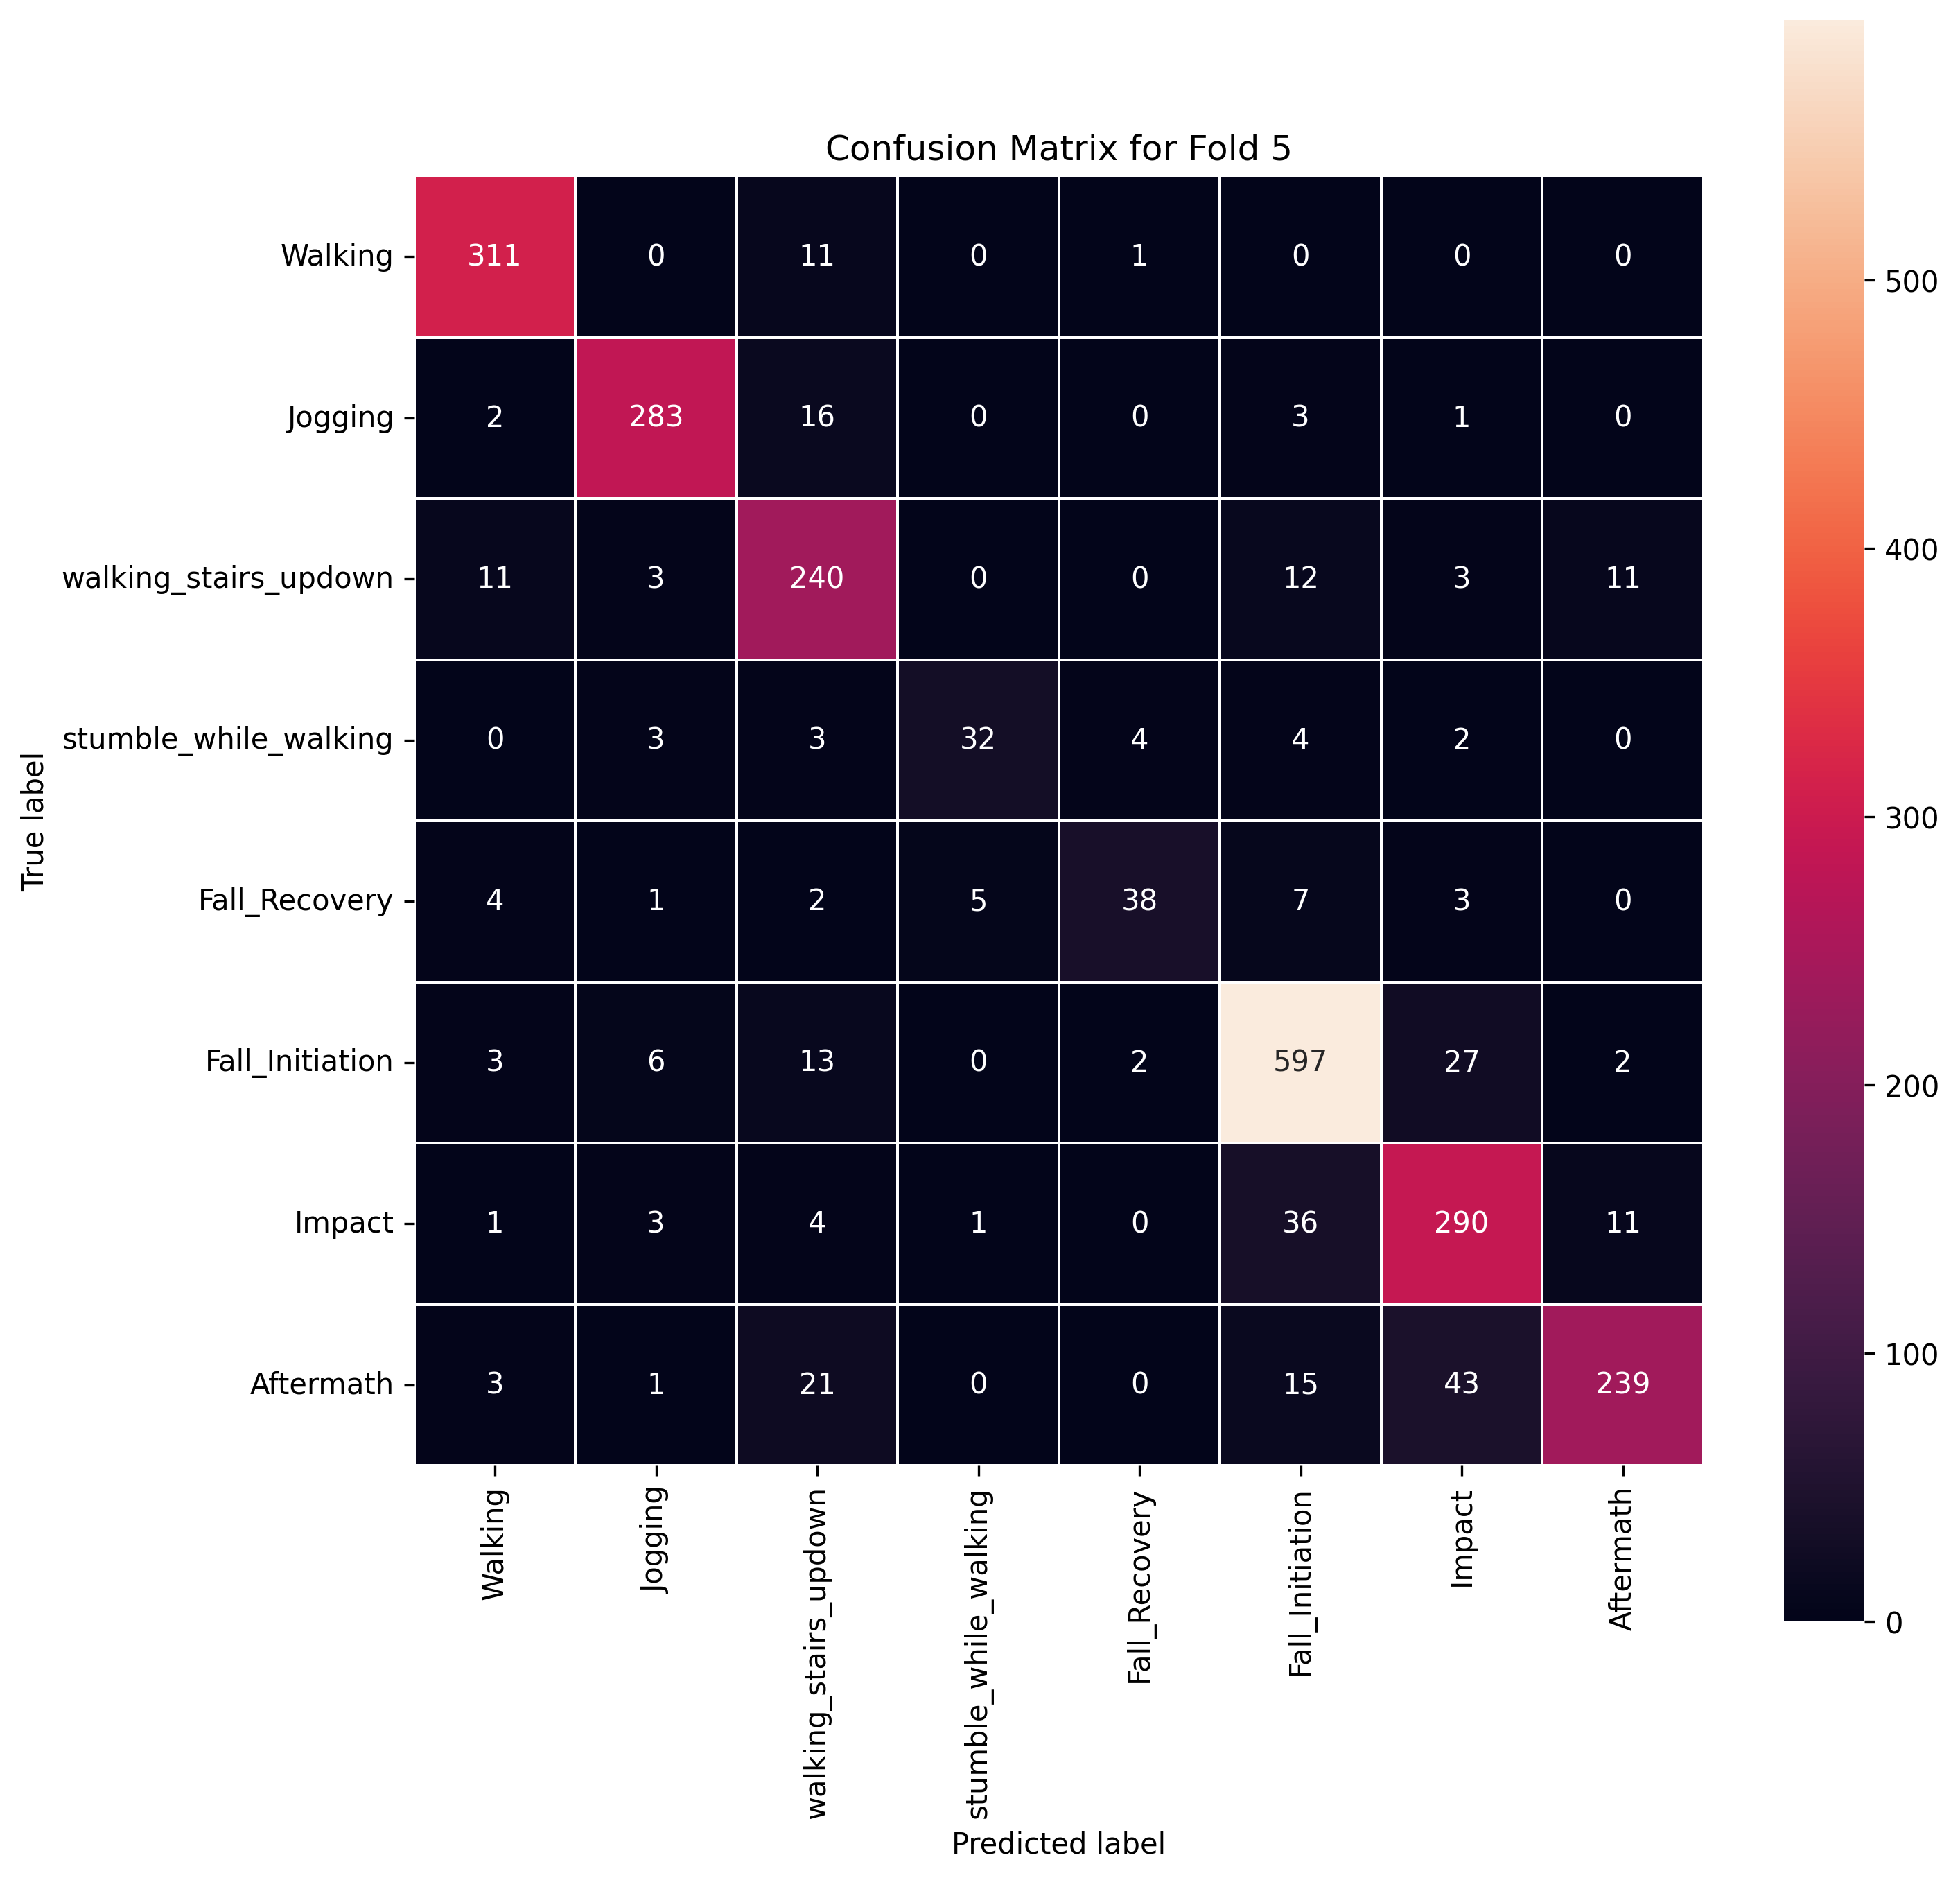

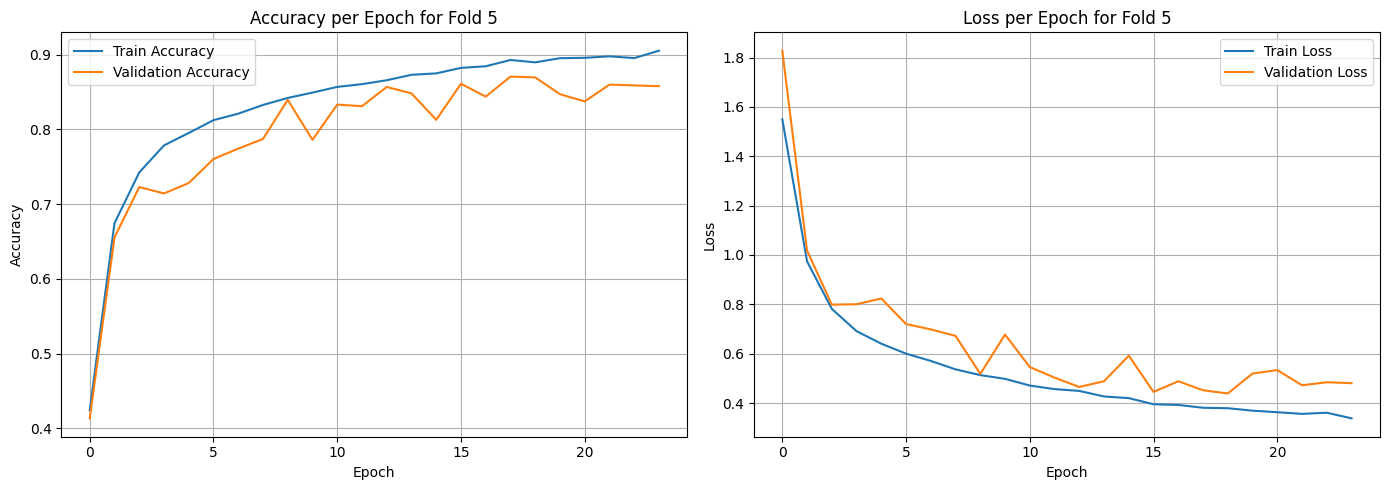

In [18]:
i = 0

# Perform 5-fold cross-validation
for train_index, test_index in folds.split(final_data):
    i += 1
    print("Fold", i)

    # Split data for the current fold
    X_train, X_test = final_data[train_index], final_data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    # Build and compile the model
    ensemble = ENSEMBLE(I_Shape, n_classes)
    ensemble.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    sk_history_ensemble = ensemble.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=30,
        shuffle=True,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    sk_results_ensemble = ensemble.evaluate(X_test, y_test, batch_size=batch_size)
    sk_ensemble_scores.append(sk_results_ensemble)

    # Make predictions
    sk_predictions_ensemble = ensemble.predict(X_test)

    # Generate confusion matrix
    sk_cm_ensemble = tf.math.confusion_matrix(y_test.argmax(axis=1), np.argmax(sk_predictions_ensemble, axis=1))
    
    # Generate classification report
    classification_report_df = pd.DataFrame(
        classification_report(y_test.argmax(axis=1), sk_predictions_ensemble.argmax(axis=1), output_dict=True)
    ).rename(
        columns=dict(zip([str(i) for i in range(0, n_classes)], list([class_labels[i] for i in range(0, n_classes)])))
    ).T
    print(classification_report_df)

    # Plot confusion matrix as a heatmap
    axis_labels = [label for label in class_labels]
    figure, ax = plt.subplots(figsize=(10, 10), dpi=300)
    sns.heatmap(sk_cm_ensemble, 
                annot=True,
                xticklabels=axis_labels, 
                yticklabels=axis_labels,
                linewidths=0.5,
                square=True,
                fmt='d',
                ax=ax)
    plt.title(f'Confusion Matrix for Fold {i}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plot accuracy and loss
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(sk_history_ensemble.history['accuracy'], label='Train Accuracy')
    plt.plot(sk_history_ensemble.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch for Fold {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(sk_history_ensemble.history['loss'], label='Train Loss')
    plt.plot(sk_history_ensemble.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch for Fold {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
# Calculate average scores
average_score = np.mean(sk_ensemble_scores, axis=0)
print(f'Average Loss across 5 folds: {average_score[0]:.4f}')
print(f'Average Accuracy across 5 folds: {average_score[1]:.4f}')

Average Loss across 5 folds: 0.4080
Average Accuracy across 5 folds: 0.8812


In [20]:
baseline_model_accuracy = ensemble.evaluate(
    X_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
keras.models.save_model(ensemble, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: [0.4294795095920563, 0.869751513004303]
Saved baseline model to: C:\Users\saatv\AppData\Local\Temp\tmpzsm1t1ku.h5


C:\Users\saatv\AppData\Local\Temp\ipykernel_1612\412374564.py:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(ensemble, keras_file, include_optimizer=False)


In [21]:
ensemble.save("ensemble.h5")

c:\Users\saatv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
ensemble.save("ensemble.keras")

In [23]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num / batch_size).astype(np.int32) * epochs

In [24]:
print(num)
print(end_step)

8406.0
34


In [25]:
# # Define model for pruning.
# pruning_params = {
#           'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                    final_sparsity=0.80,
#                                                                    begin_step=0,
#                                                                    end_step=end_step)
# }

# ensemble_prune = prune_low_magnitude(ensemble, **pruning_params)

# # `prune_low_magnitude` requires a recompile.
# ensemble_prune.compile(loss='categorical_crossentropy',
#                     optimizer='adam',
#                     metrics=['Accuracy','Precision','Recall'])

# ensemble_prune.summary()

In [26]:
# Define model for pruning
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,
        final_sparsity=0.80,
        begin_step=0,
        end_step=end_step
    )
}

In [27]:
ensemble_prune = prune_low_magnitude(ensemble, **pruning_params)

# `prune_low_magnitude` requires a recompile.
ensemble_prune.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['Accuracy'])

ensemble_prune.summary()

ValueError: Please initialize `Prune` with a supported layer. Layers should either be supported by the PruneRegistry (built-in keras layers) or should be a `PrunableLayer` instance, or should has a customer defined `get_prunable_weights` method. You passed: <class 'keras.src.layers.core.tf_op_layer.TFOpLambda'>